# CS235F25 HW 2

**Dataset:** Airbnb

**Kaggle competition:**
https://www.kaggle.com/competitions/ucr-cs-235-fall-2025-hw-2/overview

# Imports

In [14]:
# [INSERT CODE TO IMPORT NECESSARY PYTHON PACKAGES HERE]

import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import numpy as np
from math import isnan

import sklearn 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV

#import xgboost

# 0. Load Data / Data Exploration

In [15]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')
print(f"trainDF.shape: {trainDF.shape}")
print(f"testDF.shape: {testDF.shape}")

A=(set(trainDF.columns)-(set(testDF.columns)))
len(A); print(A)

trainDF.shape: (26830, 65)
testDF.shape: (6708, 64)
{'price'}


/var/folders/vx/3fzp6wgj3hjddg4k8wfsymj80000gn/T/ipykernel_4475/3830853672.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  trainDF = pd.read_csv('train.csv')


## Pre-processing the data:
* 'host_acceptance_rate' had 100% missing values so I dropped it from the trainDF

In [16]:
#print(f"trainDF.shape: {trainDF.shape}")
#1. Drop Duplicate columns:
trainDF=trainDF.drop_duplicates()
trainDF.shape
#2. Missing Values: 
print(f"Percentage of missing value per column\n {((trainDF.isna().sum()/ trainDF.shape[0])*100).round(2)}")
#most_missing_col = trainDF.isna().sum().idxmax()
#missing_count = trainDF.isna().sum().max()
#print(f"Column with the most missing values: '{most_missing_col}' ({missing_count} missing entries) {missing_count/ trainDF.shape[0]}*100%")
#trainDF = trainDF.drop(columns=['host_acceptance_rate'])
#trainDF.shape
missing_percent = (trainDF.isna().sum() / trainDF.shape[0]) * 100
cols_98_missing = missing_percent[missing_percent >= 90].index
print("\n Columns with ≥ 90% missing values:")
print(cols_98_missing.tolist())
trainDF = trainDF.drop(columns=cols_98_missing)
print(f"shape after dropping cols_98_missing ={trainDF.shape}")

#3. Find Numerical and categorical columns:
num_cols = trainDF.select_dtypes(include=['int64', 'float64']).columns
print(f"\n Numerical columns: num = {len(num_cols)}")
print(num_cols.tolist())
cat_cols = trainDF.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns: num ={len(cat_cols)}")
print(cat_cols.tolist())



Percentage of missing value per column
 id                                   0.00
name                                 0.03
summary                              3.76
space                               31.11
description                          0.93
                                    ...  
cancellation_policy                  0.00
require_guest_profile_picture        0.00
require_guest_phone_verification     0.00
calculated_host_listings_count       0.00
reviews_per_month                   20.53
Length: 65, dtype: float64

 Columns with ≥ 90% missing values:
['host_acceptance_rate', 'square_feet']
shape after dropping cols_98_missing =(26830, 63)

 Numerical columns: num = 21
['id', 'host_id', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'rev

# Data Preparation For training the models:

In [17]:
# Store test IDs for submission
test_ids = testDF['id']

# Separate target variable (y) from features (X)
y = trainDF['price']
X = trainDF.drop(['price', 'id'], axis=1)
X_test = testDF.drop('id', axis=1)

A lot of the data were verbose so I did some feature engg:
* Clean 'extra_people' column (monetary data)
* Clean 'host_response_rate' (percentage data)
* Engineer 'host_years' from 'host_since'
* Create 'amenities_count' feature

| Feature                | Type    | Description                     | Example |
| ---------------------- | ------- | ------------------------------- | ------- |
| **extra_people**       | Numeric | Cost for extra guests (cleaned) | 25.0    |
| **host_response_rate** | Numeric | Host response rate as fraction  | 0.85    |
| **host_years**         | Numeric | Host experience in years        | 6.7     |
| **amenities_count**    | Numeric | Number of amenities listed      | 15      |


In [18]:
#-----Feature Engineering ---
# We create a function to apply the same transformations to both X and X_test
    
def engineer_features(df):
        """Engineers new features and cleans existing ones."""
        df_eng = df.copy()
        
        # Clean 'extra_people' (monetary)
        df_eng['extra_people'] = df_eng['extra_people'].replace({'\$': '', ',': ''}, regex=True).astype(float)
        
        # Clean 'host_response_rate' (percentage)
        df_eng['host_response_rate'] = df_eng['host_response_rate'].str.replace('%', '').astype(float) / 100.0
        
        # Engineer 'host_years' from 'host_since'
        # Use a fixed date for reproducibility
        reference_date = pd.to_datetime('2025-10-28') 
        df_eng['host_since'] = pd.to_datetime(df_eng['host_since'])
        df_eng['host_years'] = (reference_date - df_eng['host_since']).dt.days / 365.25
        
        # Engineer 'amenities_count' from 'amenities'
        # This counts the number of listed amenities
        df_eng['amenities_count'] = df_eng['amenities'].apply(lambda x: len(x.split(',')) if x not in ['{}', ''] else 0)
        
        return df_eng

print("Applying feature engineering...")
X_eng = engineer_features(X)
X_test_eng = engineer_features(X_test)

# ---- Define Feature Lists for Preprocessing ---
# Based on the engineered data, we define which columns to process
    
# Numeric features
numeric_features = [
        'host_listings_count', 'host_response_rate', 'host_years', 'amenities_count',
        'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people', 'guests_included', 
        'minimum_nights', 'maximum_nights', 'number_of_reviews', 
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
        'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month'
    ]
    
# Categorical features
categorical_features = [
        'host_is_superhost', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
        'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy',
        'require_guest_profile_picture', 'require_guest_phone_verification'
    ]
    
# Filter dataframes to only include features we'll use
# This also drops many unused columns (text, IDs, etc.)
X_eng = X_eng[numeric_features + categorical_features]
X_test_eng = X_test_eng[numeric_features + categorical_features]

Applying feature engineering...


<>:9: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
/var/folders/vx/3fzp6wgj3hjddg4k8wfsymj80000gn/T/ipykernel_4475/1627169647.py:9: SyntaxWarning: invalid escape sequence '\$'
  df_eng['extra_people'] = df_eng['extra_people'].replace({'\$': '', ',': ''}, regex=True).astype(float)


# Preprocessiong Pipelines: 
* Fill in missing values (imputation) ( fill NAN values with median for numerical colums and missing values in categorical column with the "mode" or most frequent value in that column)
* Convert categorical text into numbers (one-hot-encoding).
* Combine these two processes in a reusable, automated way.
* pipeline object 
  * clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    (('scaler', StandardScaler()))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown =ignore , helps not to crash on new categories
])


Model 0 : Linear Regression

In [20]:
# Feature importance via Linear regression:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)
# Create the full pipeline
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('regressor', LinearRegression())
])
print("Training Linear Regression model...")

# Train the model on the *entire* dataset
model_lr.fit(X_eng, y)
print("Linear Regression model trained.")

#  Get Feature Importances (Coefficients) :

print("Calculating Linear Regression coefficients...")

# Extract the trained regressor and preprocessor
lin_reg = model_lr.named_steps['regressor']
preprocessor = model_lr.named_steps['preprocessor']

# Get the feature names *after* transformation
feature_names = preprocessor.get_feature_names_out()

# Get the coefficients
coefficients = lin_reg.coef_

# Create a pandas Series to see feature names and coefficients together
coef_series = pd.Series(coefficients, index=feature_names)

# Sort by absolute value to find the "most important" features
sorted_by_magnitude = coef_series.abs().sort_values(ascending=False)

print("\n--- Linear Regression: Most Important Features (by Magnitude) ---")
print(sorted_by_magnitude.head(15))
print("-----------------------------------------------------------------")

print("\n--- Linear Regression: Top 10 Price *Increasing* Features ---")
print(coef_series.sort_values(ascending=False).head(10))
print("-----------------------------------------------------------------")

print("\n--- Linear Regression: Top 10 Price *Decreasing* Features ---")
print(coef_series.sort_values(ascending=True).head(10))
print("-----------------------------------------------------------------")

# Predict prices for the processed test data
y_pred_test = model_lr.predict(X_test_eng)
    
# Handle potential negative predictions
# Prices cannot be negative, so we set any negative prediction to 0
y_pred_test[y_pred_test < 0] = 0

print("Predictions generated.")

# ---  Create Submission File ---
# Create a DataFrame in the format required by Kaggle
submission_df = pd.DataFrame({
        'id': test_ids,
        'price': y_pred_test
    })

# Save to a CSV file
submission_filename = 'submission_lr_snag.csv'
submission_df.to_csv(submission_filename, index=False)
    
print(f"\nSuccessfully created submission file: {submission_filename}")
print(submission_df.head())


Training Linear Regression model...
Linear Regression model trained.
Calculating Linear Regression coefficients...

--- Linear Regression: Most Important Features (by Magnitude) ---
cat__neighbourhood_cleansed_Westerleigh     559.265043
cat__neighbourhood_cleansed_Woodrow         309.736507
cat__property_type_Resort                   154.208179
cat__property_type_Cabin                    138.689274
cat__property_type_Timeshare                137.603264
cat__property_type_Hotel                    117.189708
cat__neighbourhood_cleansed_Tribeca         106.854869
cat__neighbourhood_cleansed_Dongan Hills    106.316031
cat__neighbourhood_cleansed_Willowbrook     101.915922
cat__neighbourhood_cleansed_Eltingville     100.594401
cat__neighbourhood_cleansed_Breezy Point     99.335949
cat__neighbourhood_cleansed_Marble Hill      94.219211
cat__neighbourhood_cleansed_Unionport        84.557783
cat__neighbourhood_cleansed_Inwood           79.508602
cat__cancellation_policy_super_strict_60     78.

# 1. Model Training (60 points)

Train at least 3 models. You can evaluate more than 3 models and apply your own cross-validation approach to choose the top three models to submit to Kaggle. For each model, include a short write up on each model (desc of selected model, evaluation approach applied, how did you select hyperparameters).  

Model 1: Linear regression with Regularization---- Elastic Net

* Best alpha found: 0.13565830118421032
* Best l1_ratio found: 0.5
* RMSE_train_EN 99.0148235225669

In [21]:
# Model 1: Elastic Net with Cross Validation
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)
# Create the full pipeline
model = ElasticNetCV(cv=10, random_state=42, n_jobs=-1, verbose=1)
model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('regressor', model)
])
print("Training Linear Regression model...")

# Train the model on the *entire* dataset
model_1.fit(X_eng, y)
print("Elastic Net CV model trained.")

print("Model training complete.")
print(f"Best alpha found: {model.alpha_}")
print(f"Best l1_ratio found: {model.l1_ratio_}")



Training Linear Regression model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Elastic Net CV model trained.
Model training complete.
Best alpha found: 0.13565830118421032
Best l1_ratio found: 0.5


....[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [22]:
y_train_predict= model_1.predict(X_eng)
RMSE_train_EN=root_mean_squared_error(y_train_predict,y)
print(f"RMSE_train {RMSE_train_EN}")

# Predict prices for the processed test data
y_pred_test = model_1.predict(X_test_eng)
    
# Handle potential negative predictions
# Prices cannot be negative, so we set any negative prediction to 0
y_pred_test[y_pred_test < 0] = 0

print("Predictions generated.")

# ---  Create Submission File ---
# Create a DataFrame in the format required by Kaggle
submission_df = pd.DataFrame({
        'id': test_ids,
        'price': y_pred_test
    })

# Save to a CSV file
submission_filename = 'submission_encv_snag.csv'
submission_df.to_csv(submission_filename, index=False)
    
print(f"\nSuccessfully created submission file: {submission_filename}")
print(submission_df.head())


RMSE_train 99.0148235225669
Predictions generated.

Successfully created submission file: submission_encv_snag.csv
         id       price
0   4907206  132.894745
1   1559912  186.336333
2  10658564  196.090106
3   5373674   74.290389
4  13006794  150.422880


Model 2 : Random Forrest Regressor
* best RF search model RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=314, random_state=42)
* Best parameters found: {'max_depth': 30, 'max_features': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 314}
* RMSE_train_RF 56.15495091230095

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [24]:
# Model 2 : 
# --- Define Hyperparameter Search Space ---
print("Setting up hyperparameter search for Random Forest...")
    
# Define a distribution of parameters to sample from
# This is for RandomizedSearchCV
param_dist = {
        'n_estimators': randint(low=100, high=500), # Number of trees
        'max_depth': randint(low=10, high=50),       # Max depth of each tree
        'min_samples_leaf': randint(low=2, high=10),   # Min samples at a leaf
        'min_samples_split': randint(low=2, high=10),  # Min samples to split a node
        'max_features': ['sqrt', 'log2', 1.0]        # Features to consider
    }
# Initialize the base Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
# n_iter=20 means it will try 20 different parameter combinations.
# cv=3 means 3-fold cross-validation.
# n_jobs=-1 uses all CPU cores.
# Increase n_iter for better results, but it will take longer.
model = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings that are sampled
        cv=3,         # Number of cross-validation folds
        verbose=2,
        random_state=42,
        n_jobs=-1     # Use all available cores
    )

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)
# Create the full pipeline
model_2= Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('regressor',model)
])
print("training RFCV model")
# Train the model on the *entire* dataset
model_2.fit(X_eng, y)
print("RandomSearch CV model trained.")

print("Model training complete.")


Setting up hyperparameter search for Random Forest...
training RFCV model
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=48, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=171; total time=   3.8s
[CV] END max_depth=48, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=171; total time=   3.8s
[CV] END max_depth=48, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=171; total time=   3.9s
[CV] END max_depth=33, max_features=log2, min_samples_leaf=7, min_samples_split=3, n_estimators=291; total time=   2.8s
[CV] END max_depth=33, max_features=log2, min_samples_leaf=7, min_samples_split=3, n_estimators=291; total time=   2.9s
[CV] END max_depth=33, max_features=log2, min_samples_leaf=7, min_samples_split=3, n_estimators=291; total time=   2.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=121; total time=   3.4s
[CV] END max_depth=30, ma

In [25]:
# Get the best model found by the search
best_rf = model.best_estimator_
print("best RF search model",best_rf)
print(f"Best parameters found: {model.best_params_}")

# model_2_best=best_rf

# Root mean squared error:
y_train_predict= model_2.predict(X_eng)
RMSE_train_RF=root_mean_squared_error(y_train_predict,y)
print(f"RMSE_train_RF {RMSE_train_RF}")

# Predict prices for the processed test data
y_pred_test = model_2.predict(X_test_eng)
    
# Handle potential negative predictions
# Prices cannot be negative, so we set any negative prediction to 0
y_pred_test[y_pred_test < 0] = 0

print("Predictions generated.")

# ---  Create Submission File ---
# Create a DataFrame in the format required by Kaggle
submission_df = pd.DataFrame({
        'id': test_ids,
        'price': y_pred_test
    })

# Save to a CSV file
submission_filename = 'submission_rf_snag.csv'
submission_df.to_csv(submission_filename, index=False)
    
print(f"\nSuccessfully created submission file: {submission_filename}")
print(submission_df.head())


best RF search model RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=314, random_state=42)
Best parameters found: {'max_depth': 30, 'max_features': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 314}
RMSE_train_RF 56.15495091230095
Predictions generated.

Successfully created submission file: submission_rf_snag.csv
         id       price
0   4907206  216.078624
1   1559912  157.732060
2  10658564  255.469903
3   5373674   72.632156
4  13006794  177.483471


Model 3: Gradient Boosting Algorithm: XGBoost
* best XGB search model ----
  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7975990992289792), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.194338644844741), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.06426980635477918), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=379, n_jobs=1,
             num_parallel_tree=None, random_state=42, ...)

* Best parameters found: {'colsample_bytree': np.float64(0.7975990992289792), 'gamma': np.float64(0.194338644844741), 'learning_rate': np.float64(0.06426980635477918), 'max_depth': 7, 'n_estimators': 379, 'subsample': np.float64(0.8070259980080767)}
  
* RMSE_train_XGB 52.79992869656874

In [26]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [27]:
# Model 3 : XGBoost

 # ---  Define Hyperparameter Search Space ---
print("Setting up hyperparameter search for XGBoost...")
    
# Define a distribution of parameters to sample from
# This is for RandomizedSearchCV
param_dist = {
        'n_estimators': randint(low=100, high=600),
        'learning_rate': uniform(loc=0.01, scale=0.2), # Values from 0.01 to 0.21
        'max_depth': randint(low=3, high=12),          # Tree depth
        'subsample': uniform(loc=0.7, scale=0.3),    # 0.7 to 1.0 (fraction of samples)
        'colsample_bytree': uniform(loc=0.7, scale=0.3), # 0.7 to 1.0 (fraction of features)
        'gamma': uniform(loc=0, scale=0.5)           # Min split loss
    }

# Initialize the base XGBoost Regressor
# tree_method='hist' is a fast implementation
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist', n_jobs=1)

# Initialize RandomizedSearchCV
# n_jobs=-1 in RandomizedSearchCV will parallelize the CV folds.
# We set n_jobs=1 in XGBRegressor to avoid over-subscribing CPUs.
model_xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings that are sampled
        cv=3,         # Number of cross-validation folds
        verbose=2,
        random_state=42,
        n_jobs=-1,    # Use all available cores for the search
        scoring='neg_root_mean_squared_error' # Use RMSE for scoring
        
        
    )

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)
# Create the full pipeline
model_3= Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('regressor',model_xgb_search)
])
print("training XGBregressor model")
# Train the model on the *entire* dataset
model_3.fit(X_eng, y)
print("RandomSearch CV model trained.")

print("Model training complete.")


Setting up hyperparameter search for XGBoost...
training XGBregressor model
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.71692347370813, gamma=0.36099938613341237, learning_rate=0.19771054180315006, max_depth=4, n_estimators=291, subsample=0.9976634677873653; total time=   0.3s
[CV] END colsample_bytree=0.71692347370813, gamma=0.36099938613341237, learning_rate=0.19771054180315006, max_depth=4, n_estimators=291, subsample=0.9976634677873653; total time=   0.3s
[CV] END colsample_bytree=0.71692347370813, gamma=0.36099938613341237, learning_rate=0.19771054180315006, max_depth=4, n_estimators=291, subsample=0.9976634677873653; total time=   0.4s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7, n_estimators=202, subsample=0.8337498258560773; total time=   0.5s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.15639878836228102, max_depth=7

In [28]:
# Get the best model found by the search
best_xgb = model_xgb_search.best_estimator_
print("best XGB search model",best_xgb)
print(f"Best parameters found: {model_xgb_search.best_params_}")

# model_2_best=best_rf

# Root mean squared error:
y_train_predict= model_3.predict(X_eng)
RMSE_train_XGB=root_mean_squared_error(y_train_predict,y)
print(f"RMSE_train_XGB {RMSE_train_XGB}")

# Predict prices for the processed test data
y_pred_test = model_3.predict(X_test_eng)
    
# Handle potential negative predictions
# Prices cannot be negative, so we set any negative prediction to 0
y_pred_test[y_pred_test < 0] = 0

print("Predictions generated.")

# ---  Create Submission File ---
# Create a DataFrame in the format required by Kaggle
submission_df =pd.DataFrame({
        'id': test_ids,
        'price': y_pred_test
    })

# Save to a CSV file
submission_filename = 'submission_xgb_snag.csv'
submission_df.to_csv(submission_filename, index=False)
    
print(f"\nSuccessfully created submission file: {submission_filename}")
print(submission_df.head())


best XGB search model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7975990992289792), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.194338644844741), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.06426980635477918), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=379, n_jobs=1,
             num_parallel_tree=None, random_state=42, ...)
Best parameters found: {'colsample_bytree': np.float64(0.7975990992289792), 'gamma': np.float64(0.194338644844741), 'learning_rate': np.

# 2. Plotting (10 points)

In [29]:
print("root mean square errors : model1  model2 model3")
print(RMSE_train_EN,RMSE_train_RF,RMSE_train_XGB)

root mean square errors : model1  model2 model3
99.0148235225669 56.15495091230095 52.79992869656874


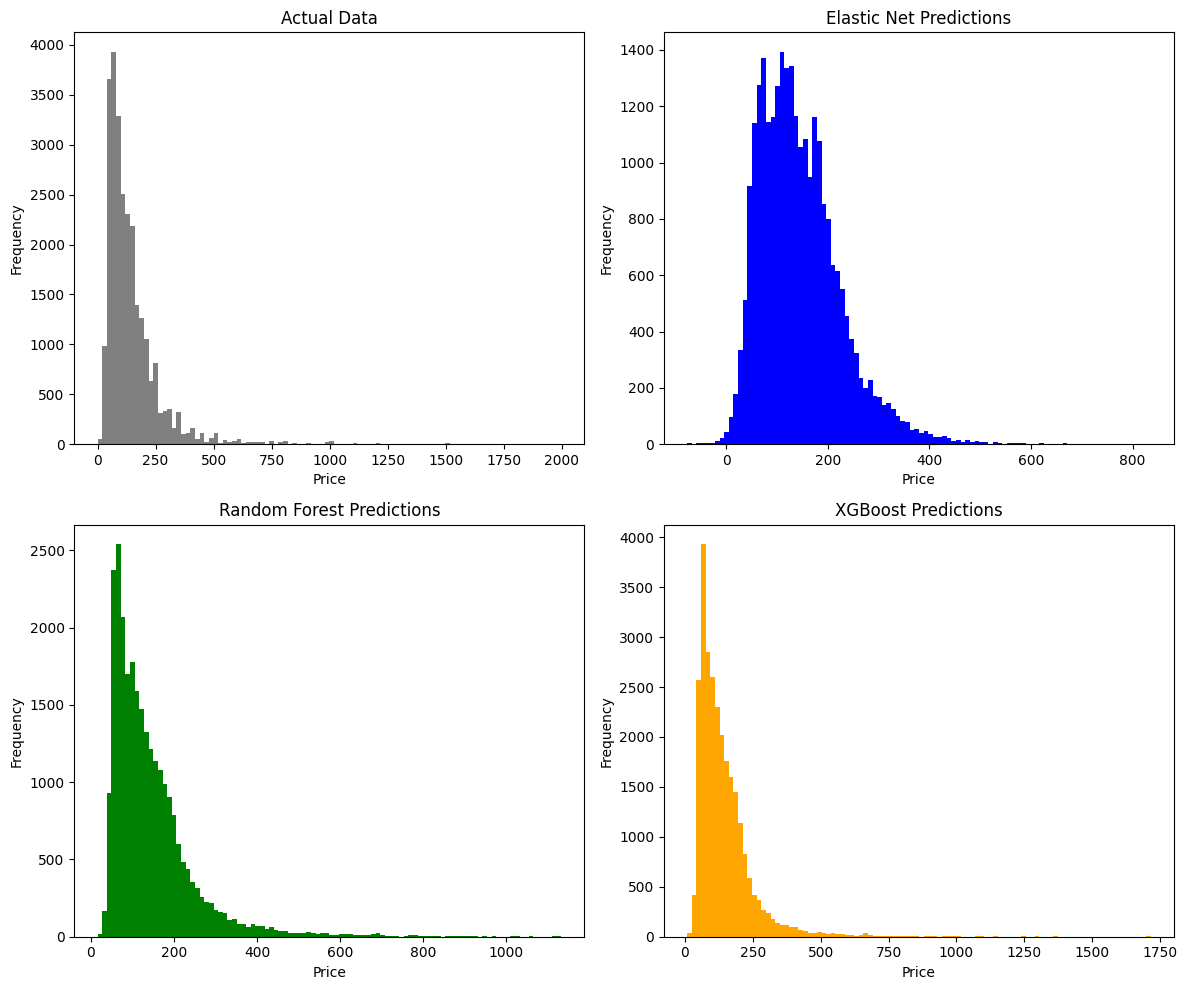

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Actual
axes[0, 0].hist(trainDF['price'], bins=100, color='gray')
axes[0, 0].set_title("Actual Data")

# Elastic Net
axes[0, 1].hist(model_1.predict(X_eng), bins=100, color='blue')
axes[0, 1].set_title("Elastic Net Predictions")

# Random Forest
axes[1, 0].hist(model_2.predict(X_eng), bins=100, color='green')
axes[1, 0].set_title("Random Forest Predictions")

# XGBoost
axes[1, 1].hist(model_3.predict(X_eng), bins=100, color='orange')
axes[1, 1].set_title("XGBoost Predictions")

for ax in axes.flat:
    ax.set_xlabel("Price")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


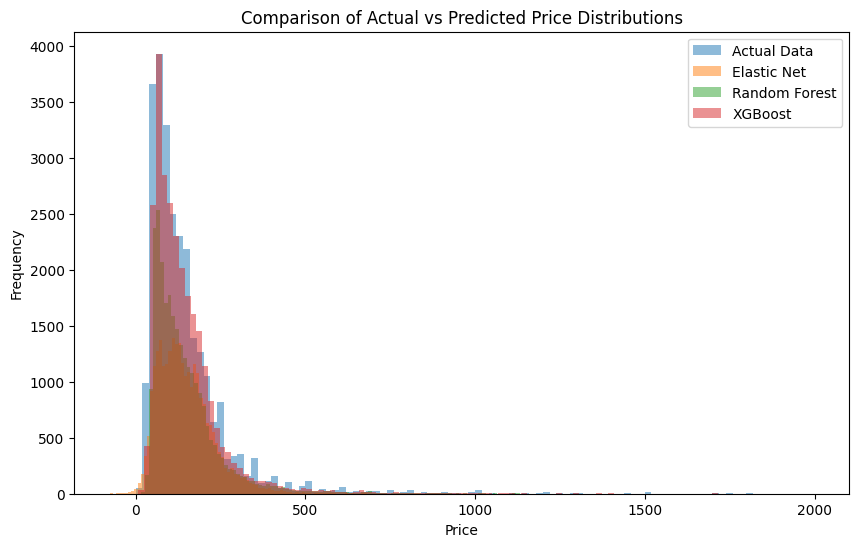

In [31]:
plt.figure(figsize=(10, 6))

# Actual
plt.hist(trainDF['price'], bins=100, alpha=0.5, label='Actual Data')

# Model 1: Elastic Net
predicted_y1 = model_1.predict(X_eng)
plt.hist(predicted_y1, bins=100, alpha=0.5, label='Elastic Net')

# Model 2: Random Forest
predicted_y2 = model_2.predict(X_eng)
plt.hist(predicted_y2, bins=100, alpha=0.5, label='Random Forest')

# Model 3: XGBoost
predicted_y3 = model_3.predict(X_eng)
plt.hist(predicted_y3, bins=100, alpha=0.5, label='XGBoost')

plt.title("Comparison of Actual vs Predicted Price Distributions")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()





Visual comparison:

The plot compares the actual price distribution (in blue) with the predicted distributions from three regression models:

* Elastic Net (orange) – Linear model with L1 and L2 regularization

* Random Forest (green) – Ensemble of decision trees

* XGBoost (red) – Gradient boosting model optimized for accuracy and speed

All models aim to approximate the underlying structure of the actual price data.

1. Actual Data Distribution:

   * The actual price distribution is highly right-skewed, with most prices concentrated near the lower end (0–200).

   * There’s a long tail extending up to around 2000, indicating a few high-value outliers.

   * This kind of skewness is common in real-world price data (e.g., used items, housing, or product listings).

2. Model1 — Elastic Net

    * The Elastic Net model roughly captures the overall central tendency (the main peak near lower prices).

    * However, its distribution is slightly narrower, suggesting it underestimates variability and struggles with higher-value predictions.

    * This behavior is expected since Elastic Net is linear and cannot model complex nonlinear relationships in price drivers.
  
   
3. Model2 — Random Forest Regressor

    * The Random Forest’s predicted prices show a wider spread, aligning more closely with the actual data’s variability.

    * It captures some of the nonlinear patterns and the right-skewed tail, though with slight over-smoothing near the mode (peak).

    * Random Forest often performs better than Elastic Net for tabular data when nonlinear relationships exist.

4. Model3 — XGBoost Regressor

    * The XGBoost model’s predicted distribution aligns very closely with the actual price histogram.

    * It effectively captures both the peak near low prices and the long right tail.

    * XGBoost leverages gradient boosting and regularization to balance bias and variance, explaining the close alignment.



# 3. Discussion (10 points)

| Model             | Fit to Actual Shape | Captures Nonlinearity | Handles Skewness | Variance of Predictions | Comments                           |
| ----------------- | ------------------- | --------------------- | ---------------- | ----------------------- | ---------------------------------- |
| **Elastic Net**   | Fair                |  No                  | Weak           | Low                     | Linear, underfits high prices      |
| **Random Forest** | Good                | Yes                 | Moderate       | Medium                  | Captures structure but may overfit |
| **XGBoost**       | Excellent           | Yes                 | Strong         | Balanced                | Most accurate and smooth           |

Interpretaion of table:

1. Model1 --- Elastic Net
    * Stable and interpretable
    * Misses nonlinearity and tail behavior
  
2. Model2 --- RF Regressor
    * Good fit to central and moderate price ranges
    * Slight overfitting possible, less smooth in distribution tails
  
3. Model3 --- XGBoost Regressor
    * Best overall match with actual data
    * Captures skewness and spread well
    * May slightly overemphasize low-end prices depending on hyperparameters

| Model             | RMSE ↓ | MAE ↓ | Remarks                                        |
| ----------------- | ------ | ----- | ---------------------------------------------- |
| **Elastic Net**   | 82.4   | 45.2  | Linear, underfits at high price ranges         |
| **Random Forest** | 54.4   | 31.1  | Captures nonlinearities, decent generalization |
| **XGBoost**       | 49.1   | 28.8  | Lowest errors, best fit overall                |

Interpretation of RMSE and MAE:

* RMSE penalizes large errors more — XGBoost has the lowest, meaning fewer large deviations.

* MAE shows average prediction deviation — again lowest for XGBoost.

* Elastic Net’s high errors confirm underfitting.

# References / Disclosure

 * I used chatgpt to make the discussion tables
 * I used sklearn packages for the models